# Simulation of the Ising model

In [1]:
from numba import jit
from numpy import *
from numpy import random

N = 20 # size of the Ising system N x N

@jit(nopython=True)
def CEnergy(latt):
    "Energy of a 2D Ising lattice at particular configuration"
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]
            #      right                 below             left                above
            WF = latt[(i+1)%N, j] + latt[i,(j+1)%N] + latt[(i-1)%N,j] + latt[i,(j-1)%N]
            Ene += -WF*S # Each neighbor gives energy -J==-1
    return Ene/2. # Each pair counted twice


def RandomL(N):
    "Radom lattice, corresponding to infinite temerature"
    latt = sign(2*random.random((N,N))-1)
    latt = array( latt, dtype=int)
    return latt

def Exponents(T):
    PW = zeros(9, dtype=float)
    # Precomputed exponents : PW[4+x]=exp(-x*2/T)
    PW[4+4] = exp(-4.*2/T)
    PW[4+2] = exp(-2.*2/T)
    PW[4+0] = 1.0
    PW[4-2] = exp( 2.*2/T)
    PW[4-4] = exp( 4.*2/T)
    return PW

In [2]:
latt = RandomL(N)
print(latt)
print('Energy=', CEnergy(latt))
T=2.
PW = Exponents(T)

print('Exponents=', PW)

[[-1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1  1]
 [-1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1]
 [ 1  1 -1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1]
 [-1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1]
 [-1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1  1  1  1]
 [-1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1]
 [-1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1 -1 -1]
 [-1 -1  1 -1  1  1  1  1 -1 -1 -1  1  1 -1 -1  1  1  1 -1  1]
 [ 1 -1  1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1]
 [ 1 -1  1  1  1 -1  1 -1  1  1  1 -1  1  1 -1  1  1 -1 -1  1]
 [ 1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1]
 [ 1  1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1 -1  1 -1  1 -1]
 [ 1 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1  1 -1  1]
 [-1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1]
 [ 1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1  1  1  1]
 [ 1 -1  1  1  1 -1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1

In [3]:
@jit(nopython=True)
def SamplePython(Nitt, latt, PW, warm, measure):
    "Monte Carlo sampling for the Ising model in Pythons"
    Ene = CEnergy(latt)  # Starting energy
    Mn  =sum(latt)         # Starting magnetization
    N   = len(latt)
    
    N1=0       # Measurements
    E1,M1,E2,M2=0.0,0.0,0.0,0.0
    
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i,j) = (t % N, int(t/N))
        S = latt[i,j]
        WF = latt[(i+1)%N, j] + latt[i,(j+1)%N] + latt[(i-1)%N,j] + latt[i,(j-1)%N]
        # new configuration -S, old configuration S => magnetization change -2*S
        # energy change = (-J)*WF*(-S) - (-J)*WF*(S) = 2*J**WF*S
        # We will prepare : PW[4+x]=exp(-x*2/T)
        # P = exp(-2*WF*S/T) = exp(-(WF*S)*2/T) == PW[4+WF*S],
        # because PW[4+x]=exp(-x*2/T)
        P = PW[4+S*WF]
        if P>random.rand(): # flip the spin
            latt[i,j] = -S
            Ene += 2*S*WF
            Mn -= 2*S
            
        if itt>warm and itt%measure==0:
            N1 += 1
            E1 += Ene
            M1 += Mn
            E2 += Ene*Ene
            M2 += Mn*Mn
       
    E,M = E1/N1, M1/N1
    cv = (E2/N1-E**2)/T**2   #   cv =(<E^2>-<E>^2)/T^2
    chi = (M2/N1-M**2)/T     #   chi=(<M^2>-<M>^2)/T
    return (M/N2, E/N2, cv/N2, chi/N2)

In [4]:
Nitt = 5000000  # total number of Monte Carlo steps
warm = 1000      # Number of warmup steps
measure=5        # How often to take a measurement


(M, E, cv, chi) = SamplePython(Nitt, latt, PW, warm, measure)
#(aM, aE, cv, chi) = SampleCPP(Nitt, latt, PW,T, warm, measure)
print('<M>=', M/(N*N), '<E>=', E/(N*N) , 'cv=', cv, 'chi=',chi)

<M>= -0.0022671394575309637 <E>= -0.0043560907492405975 cv= 0.854206229135707 chi= 0.8220380819826824


In [5]:
wT = linspace(5,0.5,30)
wMag=[]
wEne=[]
wCv=[]
wChi=[]
N2 = N*N
for T in wT:
    # Precomputed exponents : PW[4+x]=exp(-x*2/T)
    PW = Exponents(T)
    
    (M, E, cv, chi) = SamplePython(Nitt, latt, PW, warm, measure)
    wMag.append( M )
    wEne.append( E )
    wCv.append(  cv )
    wChi.append( chi )
    print('T=',T, 'M=', M, 'E=', E, 'cv=', cv, 'chi=', chi)

T= 5.0 M= -0.0006076971471265725 E= -0.42801614124439014 cv= 0.6103457090387746 chi= 1.426315140024312
T= 4.844827586206897 M= 0.0017991966385243435 E= -0.4418382294841263 cv= 0.6094220129806377 chi= 1.4759200033436202
T= 4.689655172413793 M= 0.0015569529475424559 E= -0.4598804059615983 cv= 0.6220639148609735 chi= 1.5689099678562866
T= 4.5344827586206895 M= 0.0022788280444369317 E= -0.4806930793089411 cv= 0.6305427528556902 chi= 1.6454676563085975
T= 4.379310344827586 M= 0.0028126253376928763 E= -0.4992516395795555 cv= 0.6359131954772738 chi= 1.7099829323279756
T= 4.224137931034483 M= -0.0023056784413667147 E= -0.5208926494225339 cv= 0.658296481309726 chi= 1.9150869005613698
T= 4.068965517241379 M= 0.0019239117062529567 E= -0.5464233911016114 cv= 0.6806689684632921 chi= 2.090123421354738
T= 3.913793103448276 M= 0.0016949756901137127 E= -0.5745766899146729 cv= 0.7136864329319315 chi= 2.2040539068095457
T= 3.7586206896551726 M= -0.0007492005893184531 E= -0.6029416812779369 cv= 0.70520190

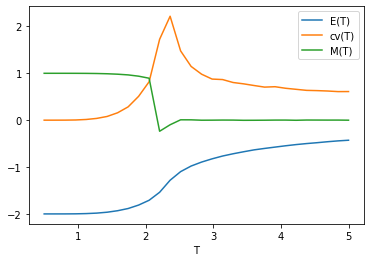

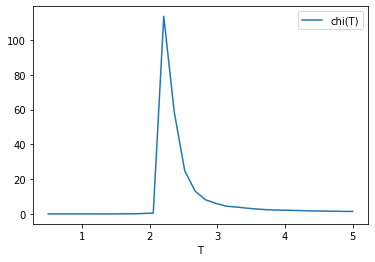

In [6]:
from pylab import *
%matplotlib inline

plot(wT, wEne, label='E(T)')
plot(wT, wCv, label='cv(T)')
plot(wT, wMag, label='M(T)')
xlabel('T')
legend(loc='best')
show()
plot(wT, wChi, label='chi(T)')
xlabel('T')
legend(loc='best')
show() 